In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/batman/Documents/ma221/gfloat/src')
import pywt
import gfloat
print(dir(gfloat))
from gfloat.formats import *
from gfloat import decode_float
from scipy.linalg import cholesky
# sys.path.append('/home/batman/Documents/cs282a/proj/test_model/fastMRI')
# from fastmri import fft2c, ifft2c, rss_complex, rss
# from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
# from fastmri.evaluate import mse, nmse, psnr, ssim

/home/batman/anaconda3/envs/fp8/lib/python3.10/site-packages/cupy/_environment.py:399: UserWarning: 
nccl library could not be loaded.

Reason: ImportError (libnccl.so.2: cannot open shared object file: No such file or directory)

You can install the library by:

  $ conda install -c conda-forge nccl

  warnings.warn(msg)
/home/batman/anaconda3/envs/fp8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['BlockFormatInfo', 'FloatClass', 'FloatValue', 'FormatInfo', 'RoundMode', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'block', 'compute_scale_amax', 'decode', 'decode_block', 'decode_float', 'decode_ndarray', 'encode', 'encode_block', 'encode_float', 'encode_ndarray', 'float_pow2str', 'float_tilde_unless_roundtrip_str', 'printing', 'quantize_block', 'round', 'round_float', 'round_ndarray', 'types']


kspace: (8, 230, 180) complex64


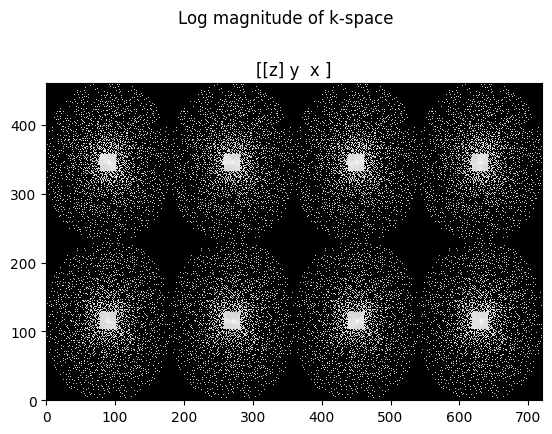

EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 133.08it/s]


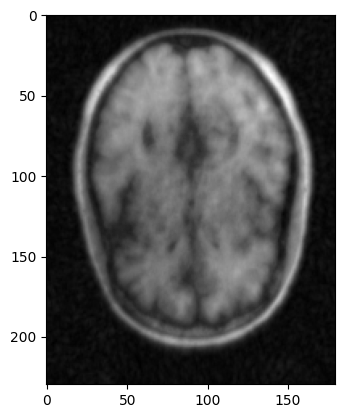

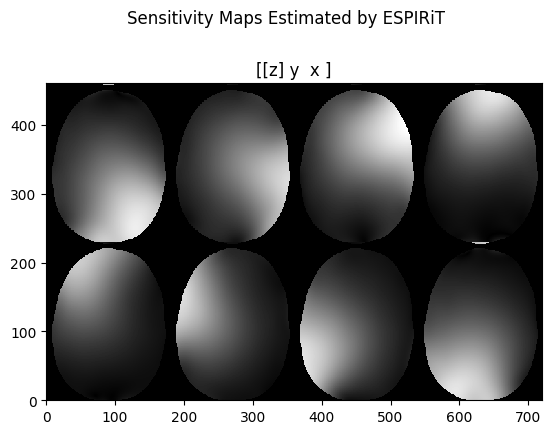

Sensitivity maps: (8, 230, 180) complex64


In [2]:
ksp_path = '/home/batman/Documents/sigpy_tutorial/sigpy-mri-tutorial/data/' # undersampled
#ksp_path = '/home/batman/Documents/ma221/proj_img/'
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)
pl.ImagePlot(ksp, mode='l', z=0, title='Log magnitude of k-space')

# undersample
# mask = mr.poisson((ksp.shape[1], ksp.shape[2]), 4)
# uksp = ksp * mask

img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0


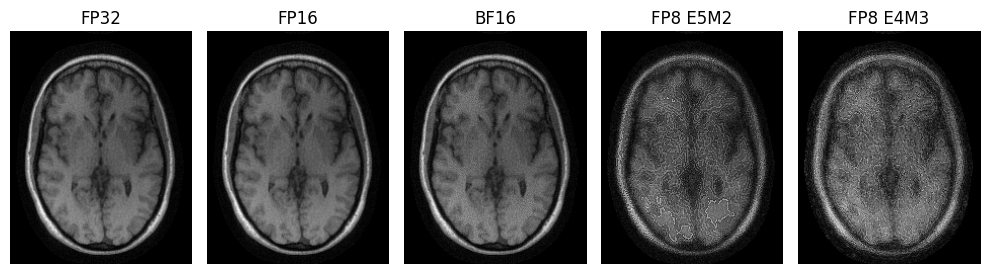

In [3]:
def to_fp8(x, format=format_info_binary32):
    fp8_real = gfloat.round_ndarray(format, x.real) #format_info_ocp_e4m3 
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction(
    kspace, 
    sensitivity_maps, 
    num_iters=10, 
    lamda=1e-2, 
    tol=1e-6, 
    use_fp16=False, 
    use_fp8=False,
    use_scaling=False, 
    format=format_info_binary32
    ):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        return W**0.5 * np.fft.fft2(shifted_image, norm='ortho')

    def adjoint_op(y):
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
        return np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    def normal_op(x):
        result = adjoint_op(forward_op(x)) + lamda * x
        if use_fp8:
            return to_fp8(result, format)  # Consider applying FP8 here sparingly
        elif use_fp16:
            return to_fp16(result, format)
        else:
            return result




    if use_fp8:
        AHy = to_fp8(adjoint_op(kspace), format)
    elif use_fp16:
        AHy = to_fp16(adjoint_op(kspace))
    else:
        AHy = adjoint_op(kspace)
    

    # Initialize variables in FP16 or FP32, no FP8 here for stability
    x = np.zeros_like(AHy, dtype=np.float16 if use_fp16 else np.complex64)
    r = AHy - normal_op(x)


    # scaling
    scale_factor = 1.0
    if use_scaling:
        scale_factor = max(np.linalg.norm(r), 1e-6)
        r /= scale_factor

    z = r.copy()
    p = z.copy()

    rz_old = np.vdot(r, z)
    resid = np.sqrt(rz_old)
    residuals = [resid]

    for i in range(num_iters):
        # Only cast Ap to FP8 if necessary
        if use_fp8:
            Ap = to_fp8(normal_op(p), format)
        elif use_fp16:
            Ap = to_fp16(normal_op(p))
        else:
            Ap = normal_op(p)

        pAp = np.vdot(p, Ap) #TODO p_fp8 here
        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        if use_scaling:
            x += alpha * p * scale_factor
        else:
            x += alpha * p
        r -= alpha * Ap

        # recompute scaling factor here (dynamic scaling)
        if use_scaling:
            scale_factor = max(np.linalg.norm(r), 1e-6)
            r /= scale_factor

        if use_fp8:
            z = to_fp8(r, format) * scale_factor  # (reduce memory here? #TODO remultiply scale factor
        elif use_fp16:
            z = to_fp16(r)
        else:
            z = r

        rz_new = np.vdot(r, z) # try r_fp8
        resid = np.sqrt(rz_new)
        residuals.append(resid)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        if use_fp8:
            p = to_fp8(z + beta * p, format)
        elif use_fp16:
            p = to_fp16(z + beta * p)
        else:
            p = z + beta * p

        rz_old = rz_new
        if i % 10 == 0:
            print("Iteration:", i) 
    # plot residuals
    # plt.figure()
    # plt.plot(residuals, label="Residual Norm")
    # plt.yscale("log")
    # plt.xlabel("Iteration")
    # plt.ylabel("Residual Norm")
    # plt.title("Residual Norm vs. Iteration")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return x


recon_img = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2)
recon_img_fp16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_binary16) 
recon_img_bf16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_bfloat16) 
recon_img_fp8_e5m2_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e5m2)
recon_img_fp8_e5m2_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e5m2) 
#recon_img_fp8_e5m2_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e5m2)  

recon_img_fp8_e4m3_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e4m3)
recon_img_fp8_e4m3_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e4m3)
recon_img_fp8_e4m3_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e4m3) 

# np.save('/home/batman/Documents/ma221/l2_recon_img', recon_img)
# np.save('/home/batman/Documents/ma221/l2_recon_img_fp16', recon_img_fp16)
# np.save('/home/batman/Documents/ma221/l2_recon_img_bf16', recon_img_bf16)
# np.save('/home/batman/Documents/ma221/l2_recon_img_fp8_e5m2', recon_img_fp8_e5m2_0p01_scale)
# np.save('/home/batman/Documents/ma221/l2_recon_img_fp8_e4m3', recon_img_fp8_e4m3_0p01_scale)
# np.save('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p1_iter5', recon_img_fp8_e5m2_0p1)
# np.save('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p1_iter5', recon_img_fp8_e4m3_0p1)



#recon_img_16b_input = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp16=False) 


plt.figure(figsize=(10,10))
plt.subplot(151)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('FP32')
plt.axis('off')
plt.subplot(152)
plt.imshow(np.abs(np.flip(recon_img_fp16)), cmap='gray')
plt.title('FP16')
plt.axis('off')
plt.subplot(153)
plt.imshow(np.abs(np.flip(recon_img_bf16)), cmap='gray')
plt.title('BF16')
plt.axis('off')
plt.subplot(154)
plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01_scale)), cmap='gray')
plt.title('FP8 E5M2')
plt.axis('off')
plt.subplot(155)
plt.imshow(np.abs(np.flip(recon_img_fp8_e4m3_0p01_scale)), cmap='gray')
plt.title('FP8 E4M3')
plt.axis('off')
plt.tight_layout()

# plt.figure(figsize=(10,5))
# plt.subplot(211)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E5M2')
# plt.axis('off')
# plt.subplot(212)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p1)), cmap='gray')
# #plt.title('FP8 E4M3')
# plt.axis('off')



### CG plus iterative refinement

Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0


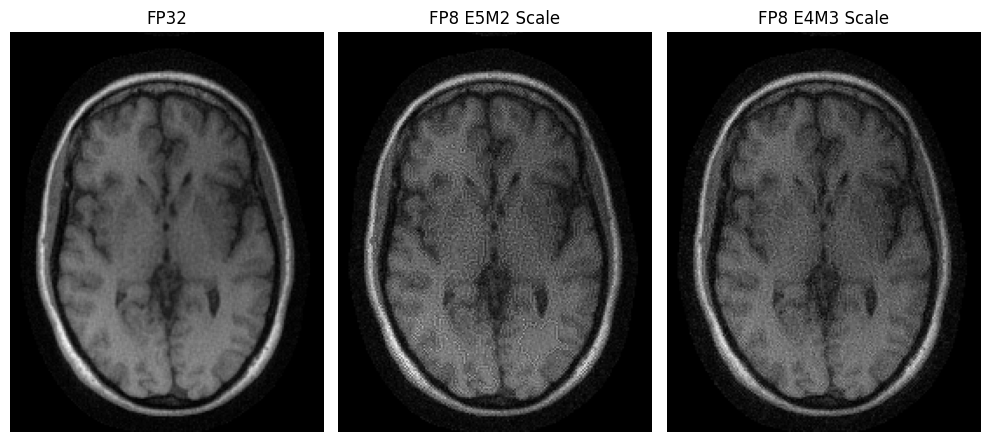

In [6]:
def to_fp8(x, format=format_info_binary32):
    fp8_real = gfloat.round_ndarray(format, x.real) 
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction(
    kspace, 
    sensitivity_maps, 
    num_iters=10, 
    lamda=1e-2, 
    tol=1e-6, 
    use_fp16=False, 
    use_fp8=False,
    use_scaling=False, 
    format=format_info_binary32,
    refinement_iters=6   # Number of refinement iterations after the initial solve
    ):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        return W**0.5 * np.fft.fft2(shifted_image, norm='ortho')

    def adjoint_op(y):
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
        return np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    def normal_op(x):
        result = adjoint_op(forward_op(x)) + lamda * x
        if use_fp8:
            return to_fp8(result, format)  
        elif use_fp16:
            return to_fp16(result)
        else:
            return result

    # Initial computations
    if use_fp8:
        AHy = to_fp8(adjoint_op(kspace), format)
    elif use_fp16:
        AHy = to_fp16(adjoint_op(kspace))
    else:
        AHy = adjoint_op(kspace)

    x = np.zeros_like(AHy, dtype=np.complex64 if not use_fp16 else np.float16)  # Store x in complex64 if no FP16
    r = AHy - normal_op(x)

    # scaling
    scale_factor = 1.0
    if use_scaling:
        scale_factor = max(np.linalg.norm(r), 1e-6)
        r /= scale_factor

    z = r.copy()
    p = z.copy()

    rz_old = np.vdot(r, z)
    resid = np.sqrt(rz_old)
    residuals = [resid]

    for i in range(num_iters):
        if use_fp8:
            Ap = to_fp8(normal_op(p), format)
        elif use_fp16:
            Ap = to_fp16(normal_op(p))
        else:
            Ap = normal_op(p)

        pAp = np.vdot(p, Ap)
        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        if use_scaling:
            x += alpha * p * scale_factor
        else:
            x += alpha * p
        r -= alpha * Ap

        # Dynamic scaling
        if use_scaling:
            scale_factor = max(np.linalg.norm(r), 1e-6)
            r /= scale_factor

        if use_fp8:
            z = to_fp8(r, format)  # The scaling factor has been applied above
        elif use_fp16:
            z = to_fp16(r)
        else:
            z = r

        rz_new = np.vdot(r, z)
        resid = np.sqrt(rz_new)
        residuals.append(resid)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        if use_fp8:
            p = to_fp8(z + beta * p, format)
        elif use_fp16:
            p = to_fp16(z + beta * p)
        else:
            p = z + beta * p

        rz_old = rz_new
        if i % 10 == 0:
            print("Iteration:", i)

    # -------------------------------
    # Iterative Refinement Step
    # -------------------------------
    # after finishing the low-precision CG solve, do a higher recision refinement.
    # first cast x to a stable precision (e.g., FP32).
    x_refine = x.astype(np.complex64)

    # Compute residual in higher precision
    # NOTE: Here we temporarily turn off use_fp8/use_fp16 logic to ensure refinement is done in full FP32
    _use_fp8, _use_fp16 = use_fp8, use_fp16
    use_fp8, use_fp16 = False, False

    r_refine = adjoint_op(kspace) - (adjoint_op(forward_op(x_refine)) + lamda * x_refine)

    # Solve A dx = r in FP32 using a small number of CG steps without scaling or low precision
    dx = np.zeros_like(x_refine, dtype=np.complex64)
    rr = r_refine.copy()
    zz = rr.copy()
    pp = zz.copy()

    rr_old = np.vdot(rr, zz)

    for j in range(refinement_iters):
        Ap = adjoint_op(forward_op(pp)) + lamda * pp
        pAp = np.vdot(pp, Ap)
        if pAp <= 0:
            print("Matrix not positive definite in refinement. Stopping refinement.")
            break

        alpha = rr_old / pAp
        dx += alpha * pp
        rr -= alpha * Ap

        rr_new = np.vdot(rr, rr)
        if np.sqrt(rr_new) < tol:
            print(f'Refinement converged after {j+1} steps.')
            break

        beta = rr_new / rr_old
        pp = rr + beta * pp
        rr_old = rr_new

    # Update solution with the refinement correction
    x_final = x_refine + dx

    # Restore original use_fp8/use_fp16 flags
    use_fp8, use_fp16 = _use_fp8, _use_fp16

    return x_final






recon_img = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2)
# recon_img_fp16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, format=format_info_binary16) 
# recon_img_bf16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, format=format_info_bfloat16) 
recon_img_fp8_e5m2_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e5m2)
recon_img_fp8_e5m2_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e5m2) 
#recon_img_fp8_e5m2_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e5m2)  

recon_img_fp8_e4m3_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e4m3)
#recon_img_fp8_e4m3_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e4m3)
recon_img_fp8_e4m3_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e4m3) 

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('FP32')
plt.axis('off')
# plt.subplot(152)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E5M2')
# plt.axis('off')
# plt.subplot(153)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E4M3')
# plt.axis('off')
plt.subplot(132)
plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01_scale)), cmap='gray')
plt.title('FP8 E5M2 Scale')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.abs(np.flip(recon_img_fp8_e4m3_0p01_scale)), cmap='gray')
plt.title('FP8 E4M3 Scale')
plt.axis('off')
plt.tight_layout()

# plt.figure(figsize=(10,10))
# print(len(img_e5m2))
# for i in img_e5m2:
#     plt.imshow(np.abs(np.flip(i)), cmap='gray')
#     plt.show()




Iteration: 0
Iteration: 10
Iteration: 0
Iteration: 10
Iteration: 0
Iteration: 10


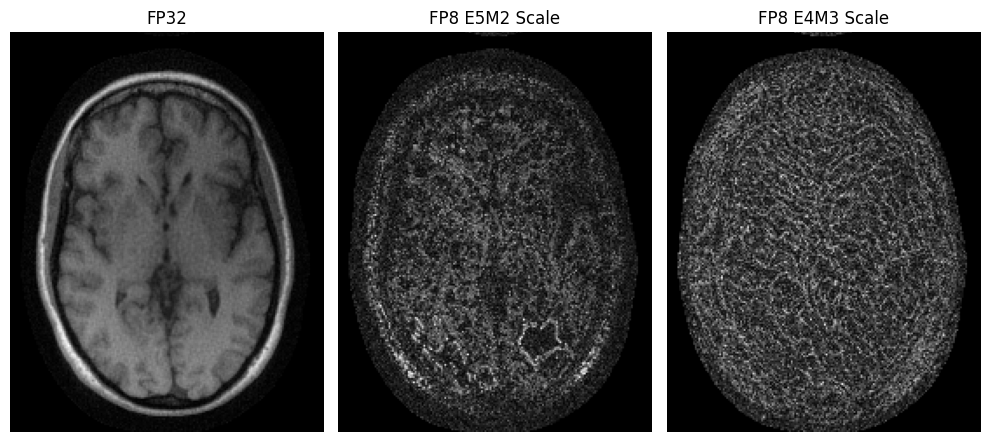

In [12]:
# Assume gfloat and format_info_binary32 or other FP8 formats are defined elsewhere

def to_fp8(x, format):
    fp8_real = gfloat.round_ndarray(format, x.real)
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction(
    kspace, 
    sensitivity_maps, 
    num_iters=15, 
    lamda=1e-2, 
    tol=1e-6, 
    use_fp16=False, 
    use_fp8=True,
    use_scaling=False, 
    format=format_info_binary32,
    refinement_iters=0,
    simulate_fp8_arithmetic=False
    ):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        y = W**0.5 * np.fft.fft2(shifted_image, norm='ortho')
        # If simulating FP8 arithmetic, quantize the output
        if simulate_fp8_arithmetic and use_fp8:
            y = to_fp8(y, format)
        return y

    def adjoint_op(y):
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
        x = np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)
        # If simulating FP8 arithmetic, quantize the output
        if simulate_fp8_arithmetic and use_fp8:
            x = to_fp8(x, format)
        return x

    def normal_op(x):
        # Compute A^H A x + lamda x
        Ax = adjoint_op(forward_op(x)) + lamda * x
        # Quantize if in FP8 mode
        if use_fp8:
            Ax = to_fp8(Ax, format)
        elif use_fp16:
            Ax = to_fp16(Ax)
        return Ax

    # Compute A^H y in chosen precision
    AHy = adjoint_op(kspace)
    if use_fp8:
        AHy = to_fp8(AHy, format)
    elif use_fp16:
        AHy = to_fp16(AHy)

    # Initialize
    if use_fp16:
        x = np.zeros_like(AHy, dtype=np.float16)
    else:
        x = np.zeros_like(AHy, dtype=np.complex64)

    r = AHy - normal_op(x)
    # if simulate_fp8_arithmetic and use_fp8:
    #     r = to_fp8(r, format)

    scale_factor = 1.0
    if use_scaling:
        scale_factor = max(np.linalg.norm(r), 1e-6)
        r /= scale_factor
        if simulate_fp8_arithmetic and use_fp8:
            r = to_fp8(r, format)

    z = r.copy()
    p = z.copy()

    rz_old = np.vdot(r, z)
    if simulate_fp8_arithmetic and use_fp8:
        # Quantize scalars by quantizing a small array
        rz_old_array = np.array([rz_old], dtype=np.complex64)
        rz_old_array = to_fp8(rz_old_array, format)
        rz_old = rz_old_array[0]

    resid = np.sqrt(rz_old.real)  # rz_old should be real if the system is Hermitian
    residuals = [resid]

    for i in range(num_iters):
        Ap = normal_op(p)
        if simulate_fp8_arithmetic and use_fp8:
            Ap = to_fp8(Ap, format)

        # Dot product pAp
        pAp = np.vdot(p, Ap)
        # Quantize pAp if simulating FP8
        if simulate_fp8_arithmetic and use_fp8:
            pAp_arr = np.array([pAp], dtype=np.complex64)
            pAp_arr = to_fp8(pAp_arr, format)
            pAp = pAp_arr[0]

        if pAp.real <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        # If simulating FP8, quantize alpha
        if simulate_fp8_arithmetic and use_fp8:
            alpha_arr = np.array([alpha], dtype=np.complex64)
            alpha_arr = to_fp8(alpha_arr, format)
            alpha = alpha_arr[0]

        # x = x + alpha * p
        x = x + alpha * p
        if simulate_fp8_arithmetic and use_fp8:
            x = to_fp8(x, format)

        # r = r - alpha * Ap
        r = r - alpha * Ap
        if use_scaling:
            scale_factor = max(np.linalg.norm(r), 1e-6)
            r = r / scale_factor
        if simulate_fp8_arithmetic and use_fp8:
            r = to_fp8(r, format)

        z = r
        rz_new = np.vdot(r, z)
        # Quantize rz_new if simulating FP8
        if simulate_fp8_arithmetic and use_fp8:
            rz_new_arr = np.array([rz_new], dtype=np.complex64)
            #rz_new_arr = to_fp8(rz_new_arr, format)
            rz_new = rz_new_arr[0]

        resid = np.sqrt(rz_new.real)
        residuals.append(resid)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        # Quantize beta
        if simulate_fp8_arithmetic and use_fp8:
            beta_arr = np.array([beta], dtype=np.complex64)
            beta_arr = to_fp8(beta_arr, format)
            beta = beta_arr[0]

        p = z + beta * p
        if simulate_fp8_arithmetic and use_fp8:
            p = to_fp8(p, format)

        rz_old = rz_new
        if i % 10 == 0:
            print("Iteration:", i)

    # -------------------------------
    # Iterative Refinement Step in Full Precision (No FP8 Simulation)
    # -------------------------------
    # Convert x to a stable precision (FP32) for refinement
    x_refine = x.astype(np.complex64)

    # Turn off FP8 logic for refinement
    _use_fp8, _use_fp16, _simulate_fp8_arithmetic = use_fp8, use_fp16, simulate_fp8_arithmetic
    use_fp8, use_fp16, simulate_fp8_arithmetic = False, False, False

    # Compute residual in full precision
    r_refine = adjoint_op(kspace) - (adjoint_op(forward_op(x_refine)) + lamda * x_refine)

    # Solve A dx = r_refine with a few CG steps in FP32
    dx = np.zeros_like(x_refine, dtype=np.complex64)
    rr = r_refine.copy()
    zz = rr.copy()
    pp = zz.copy()

    rr_old = np.vdot(rr, zz)

    for j in range(refinement_iters):
        Ap = adjoint_op(forward_op(pp)) + lamda * pp
        pAp = np.vdot(pp, Ap)
        if pAp.real <= 0:
            print("Matrix not positive definite in refinement. Stopping refinement.")
            break

        alpha = rr_old / pAp
        dx += alpha * pp
        rr -= alpha * Ap

        rr_new = np.vdot(rr, rr)
        if np.sqrt(rr_new.real) < tol:
            print(f'Refinement converged after {j+1} steps.')
            break

        beta = rr_new / rr_old
        pp = rr + beta * pp
        rr_old = rr_new

    x_final = x_refine + dx

    # Restore original flags
    use_fp8, use_fp16, simulate_fp8_arithmetic = _use_fp8, _use_fp16, _simulate_fp8_arithmetic

    return x_final

recon_img = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, simulate_fp8_arithmetic=False)
# recon_img_fp16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, format=format_info_binary16) 
# recon_img_bf16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, format=format_info_bfloat16) 
#recon_img_fp8_e5m2_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e5m2)
recon_img_fp8_e5m2_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e5m2) 
#recon_img_fp8_e5m2_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e5m2)  

#recon_img_fp8_e4m3_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e4m3)
#recon_img_fp8_e4m3_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e4m3)
recon_img_fp8_e4m3_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e4m3) 

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('FP32')
plt.axis('off')
# plt.subplot(152)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E5M2')
# plt.axis('off')
# plt.subplot(153)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E4M3')
# plt.axis('off')
plt.subplot(132)
plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01_scale)), cmap='gray')
plt.title('FP8 E5M2 Scale')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.abs(np.flip(recon_img_fp8_e4m3_0p01_scale)), cmap='gray')
plt.title('FP8 E4M3 Scale')
plt.axis('off')
plt.tight_layout()


### CG + Iterative Refinement working

Iteration: 0
Iteration: 5
Iteration: 0
Iteration: 5
Iteration: 0
Iteration: 5


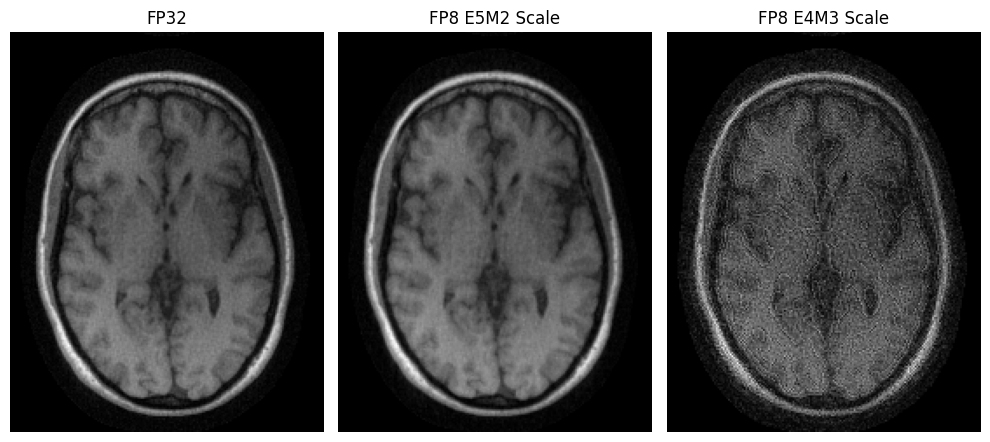

In [8]:
def to_fp8(x, format):
    fp8_real = gfloat.round_ndarray(format, x.real)
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def conjugate_sense_reconstruction(
    kspace, 
    sensitivity_maps, 
    num_iters=10, 
    lamda=1e-2, 
    tol=1e-6, 
    use_fp8=True,  # Single flag for FP8 simulation
    use_scaling=False, 
    format=format_info_binary32,
    refinement_iters=4
    ):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        y = W**0.5 * np.fft.fft2(shifted_image, norm='ortho')
        if use_fp8:
            y = to_fp8(y, format)
        return y

    def adjoint_op(y):
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
        x = np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)
        if use_fp8:
            x = to_fp8(x, format)
        return x

    def normal_op(x):
        Ax = adjoint_op(forward_op(x)) + lamda * x
        if use_fp8:
            Ax = to_fp8(Ax, format)
        return Ax

    # Initial computations
    AHy = adjoint_op(kspace)
    if use_fp8:
        AHy = to_fp8(AHy, format)

    # Initialize x in FP8 if using FP8
    x = np.zeros_like(AHy, dtype=np.complex64)
    if use_fp8:
        x = to_fp8(x, format)

    # Compute initial residual in FP32
    r = AHy - normal_op(x)  # Keep in FP32!

    # Scaling (if used) in FP32
    scale_factor = 1.0
    if use_scaling:
        scale_factor = max(np.linalg.norm(r), 1e-6)
        r /= scale_factor

    # Initialize other vectors
    z = r.copy()  # z will be in FP8 if use_fp8
    if use_fp8:
        z = to_fp8(z, format)
    p = z.copy()

    # Initial inner product in FP8 if specified
    rz_old = np.vdot(r, z)  # r is FP32, z is FP8 if use_fp8
    if use_fp8:
        rz_old_array = np.array([rz_old], dtype=np.complex64)
        rz_old = to_fp8(rz_old_array, format)[0]

    resid = np.sqrt(rz_old.real)
    residuals = [resid]

    for i in range(num_iters):
        # Matrix-vector product in current precision
        Ap = normal_op(p)

        # Compute step size
        pAp = np.vdot(p, Ap)
        if use_fp8:
            pAp_arr = np.array([pAp], dtype=np.complex64)
            pAp = to_fp8(pAp_arr, format)[0]

        if pAp.real <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        if use_fp8:
            alpha_arr = np.array([alpha], dtype=np.complex64)
            alpha = to_fp8(alpha_arr, format)[0]

        # Update solution in FP8
        x_update = alpha * p
        if use_fp8:
            x_update = to_fp8(x_update, format)
        x = x + x_update
        if use_fp8:
            x = to_fp8(x, format)

        # Update residual in FP32
        r = r - alpha * Ap  # Keep in FP32!

        # Apply scaling in FP32 if used
        if use_scaling:
            scale_factor = max(np.linalg.norm(r), 1e-6)
            r = r / scale_factor

        # Update z in FP8 if specified
        z = r.copy()
        if use_fp8:
            z = to_fp8(z, format)

        # Compute new inner products
        rz_new = np.vdot(r, z)  # r is FP32, z is FP8 if use_fp8
        if use_fp8:
            rz_new_arr = np.array([rz_new], dtype=np.complex64)
            rz_new = to_fp8(rz_new_arr, format)[0]

        resid = np.sqrt(rz_new.real)
        residuals.append(resid)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        if use_fp8:
            beta_arr = np.array([beta], dtype=np.complex64)
            beta = to_fp8(beta_arr, format)[0]

        # Update direction in FP8
        p = z + beta * p
        if use_fp8:
            p = to_fp8(p, format)

        rz_old = rz_new
        if i % 5 == 0:
            print("Iteration:", i)

    # -------------------------------
    # Iterative Refinement Step in FP32
    # -------------------------------
    x_refine = x.astype(np.complex64)
    _use_fp8 = use_fp8
    use_fp8 = False

    # Compute residual in FP32
    r_refine = adjoint_op(kspace) - (adjoint_op(forward_op(x_refine)) + lamda * x_refine)

    # Solve correction equation in FP32
    dx = np.zeros_like(x_refine, dtype=np.complex64)
    rr = r_refine.copy()
    zz = rr.copy()
    pp = zz.copy()
    rr_old = np.vdot(rr, zz)

    for j in range(refinement_iters):
        Ap = adjoint_op(forward_op(pp)) + lamda * pp
        pAp = np.vdot(pp, Ap)
        
        if pAp.real <= 0:
            print("Matrix not positive definite in refinement. Stopping refinement.")
            break

        alpha = rr_old / pAp
        dx += alpha * pp
        rr -= alpha * Ap

        rr_new = np.vdot(rr, rr)
        if np.sqrt(rr_new.real) < tol:
            print(f'Refinement converged after {j+1} steps.')
            break

        beta = rr_new / rr_old
        pp = rr + beta * pp
        rr_old = rr_new

    x_final = x_refine + dx
    use_fp8 = _use_fp8

    return x_final

recon_img = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False)
# recon_img_fp16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, format=format_info_binary16) 
# recon_img_bf16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=False, format=format_info_bfloat16) 
#recon_img_fp8_e5m2_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e5m2)
recon_img_fp8_e5m2_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e5m2) 
#recon_img_fp8_e5m2_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e5m2)  

#recon_img_fp8_e4m3_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e4m3)
#recon_img_fp8_e4m3_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e4m3)
recon_img_fp8_e4m3_0p01_scale = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, use_scaling=True, format=format_info_ocp_e4m3) 

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('FP32')
plt.axis('off')
# plt.subplot(152)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E5M2')
# plt.axis('off')
# plt.subplot(153)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E4M3')
# plt.axis('off')
plt.subplot(132)
plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01_scale)), cmap='gray')
plt.title('FP8 E5M2 Scale')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.abs(np.flip(recon_img_fp8_e4m3_0p01_scale)), cmap='gray')
plt.title('FP8 E4M3 Scale')
plt.axis('off')
plt.tight_layout()

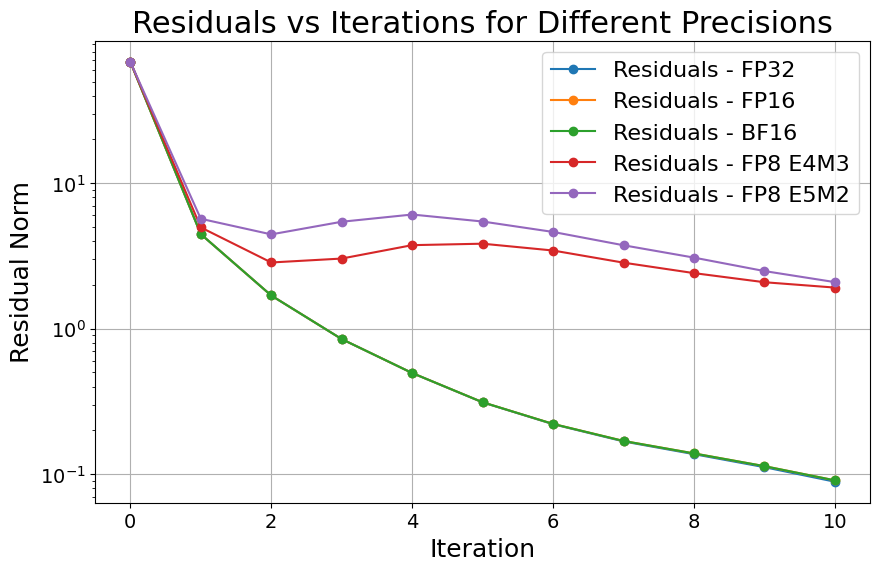

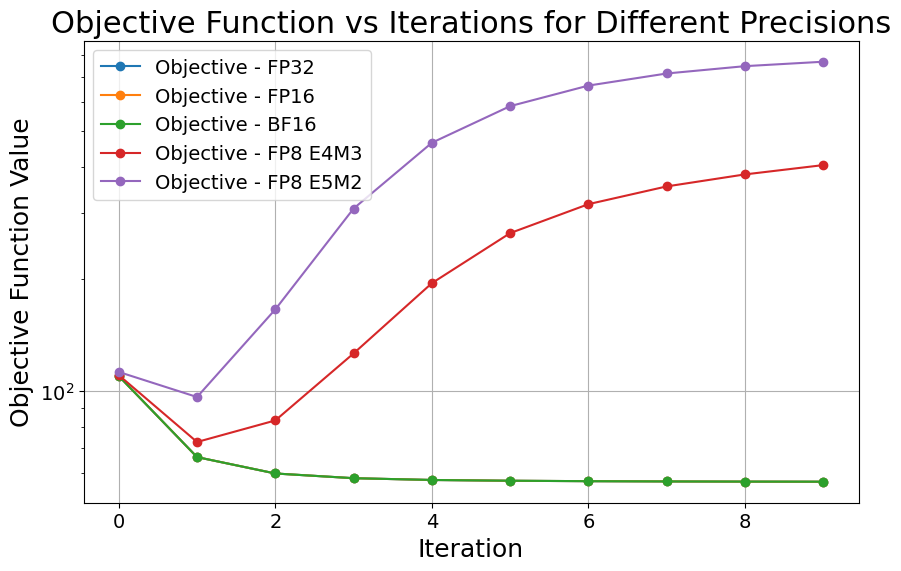

In [22]:
# Define dictionaries to store residuals and objective function values for each precision type
residuals_dict = {}
objective_dict = {}

def conjugate_sense_reconstruction(
    kspace, 
    sensitivity_maps, 
    num_iters=10, 
    lamda=1e-2, 
    tol=1e-6, 
    use_fp16=False, 
    use_fp8=False,
    use_scaling=False, 
    format=format_info_binary32,
    label=None
    ):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        return W**0.5 * np.fft.fft2(shifted_image, norm='ortho')

    def adjoint_op(y):
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
        return np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    def normal_op(x):
        result = adjoint_op(forward_op(x)) + lamda * x
        if use_fp8:
            return to_fp8(result, format)
        elif use_fp16:
            return to_fp16(result)
        else:
            return result

    if use_fp8:
        AHy = to_fp8(adjoint_op(kspace), format)
    elif use_fp16:
        AHy = to_fp16(adjoint_op(kspace))
    else:
        AHy = adjoint_op(kspace)
    
    x = np.zeros_like(AHy, dtype=np.float16 if use_fp16 else np.complex64)
    r = AHy - normal_op(x)
    scale_factor = max(np.linalg.norm(r), 1e-6) if use_scaling else 1.0
    r /= scale_factor if use_scaling else 1.0
    z = r.copy()
    p = z.copy()
    rz_old = np.vdot(r, z)
    resid = np.sqrt(rz_old)
    residuals = [resid]
    objectives = []

    for i in range(num_iters):
        Ap = normal_op(p)
        pAp = np.vdot(p, Ap)
        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        x += alpha * p
        r -= alpha * Ap
        if use_scaling:
            scale_factor = max(np.linalg.norm(r), 1e-6)
            r /= scale_factor
        z = r
        rz_new = np.vdot(r, z)
        resid = np.sqrt(rz_new)
        residuals.append(resid)

        # Compute objective function value
        objective = np.linalg.norm(forward_op(x) - kspace)**2 + lamda * np.linalg.norm(x)**2
        objectives.append(objective)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        p = z + beta * p
        rz_old = rz_new

    # Store residuals and objectives in the dictionaries
    if label:
        residuals_dict[label] = residuals
        objective_dict[label] = objectives

    return x

# Run the function with different precision types and labels
x_fp32 = conjugate_sense_reconstruction(ksp, mps, num_iters=10, label="FP32")
x_fp16 = conjugate_sense_reconstruction(ksp, mps, num_iters=10, use_fp8=True, format=format_info_binary16, label="FP16")
x_bf16 = conjugate_sense_reconstruction(ksp, mps, num_iters=10, use_fp8=True, format=format_info_binary16, label="BF16")
x_fp8_e4m3 = conjugate_sense_reconstruction(ksp, mps, num_iters=10, use_fp8=True, format=format_info_ocp_e4m3, label="FP8 E4M3")
x_fp8_e4m3 = conjugate_sense_reconstruction(ksp, mps, num_iters=10, use_fp8=True, format=format_info_ocp_e5m2, label="FP8 E5M2")

# Plot all residuals
plt.figure(figsize=(10, 6))
for label, residuals in residuals_dict.items():
    plt.plot(residuals, marker='o', label=f'Residuals - {label}')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Residual Norm', fontsize=18)
plt.title('Residuals vs Iterations for Different Precisions', fontsize=22)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

# Plot all objective functions
plt.figure(figsize=(10, 6))
for label, objectives in objective_dict.items():
    plt.plot(objectives, marker='o', label=f'Objective - {label}')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Objective Function Value', fontsize=18)
plt.title('Objective Function vs Iterations for Different Precisions', fontsize=22)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()
